In [ ]:
#Get access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Python module Twint sometimes can be inconsistent
#IP may be blacklisted by some Twitter users for a while and have to wait approximately 15 min to run the code again
#Depends on luck...

#Install Twint
#pip install twint
#!pip uninstall -q twint -y
#!pip3 install git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip3 install git+https://github.com/Museum-Barberini/twint.git@fix/RefreshTokenException#egg=twint
#!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

#May need to change this in token.py if Error: twint.token.RefreshTokenException
#https://github.com/Museum-Barberini/twint/edit/fix/RefreshTokenException/twint/token.py

In [ ]:
!pip install wikipedia-api
!pip install nltk

In [ ]:
#Modules
import pandas as pd
import numpy as np
import sqlite3
import nltk
import sys
import os
import re
import wikipediaapi as wikip
from nltk.corpus import wordnet as wn
import nest_asyncio
nest_asyncio.apply()
import twint
import requests
from os.path import exists
from urllib.error import HTTPError

In [ ]:

#1. Create SQL table
def create_sql_table():

    cursor.execute('''
            CREATE TABLE IF NOT EXISTS Usernames(
            NAME varchar(100),
            USERNAME varchar(100),
            FOLLOWERS varchar(100),
            FOLLOWING varchar(100),
            TWEETS varchar(100),
            JOIN_DATE varchar(100)
            )''')     

    conn.commit()
    
#2. Extract data form websites
def data_from_links():
    empty_list = [[1,1]]
    data_from_links.username_list = np.array(empty_list, dtype=str)
    for num in range(len(url_list)):
        csv_file = r'C:\python files\csv\URLtable{}.csv'.format(num)
        try:
            #download table to csv file so that we don't have to load websites everytimes
            if exists(csv_file):
                url_table = pd.read_csv(csv_file)
            else:
                url_table = pd.read_html(url_list[num])[0]
                url_table.to_csv(csv_file, index=False)
            
            for num2 in range(len(url_table)):

                #Only get important data which is the name of Twitter users from links
                raw_username = url_table.loc[num2][2]
                
                #Shape data by removing invalid syntax
                name = str(raw_username.split(' (')[0]).replace(" ", "_").replace("'", "_")
                username = str(raw_username.split(' (')[1]).replace(")", "").replace("_","")
                names = np.array([name, username])
                data_from_links.username_list = np.append(data_from_links.username_list, [names], axis=0)

        except HTTPError:
            print("Error when loading the following url : " + url_list[num])
            if num == 0:
                global top_fifty_acc_val
                top_fifty_acc_val = 1
            continue
    
    #Remove default value in list
    data_from_links.username_list = np.delete(data_from_links.username_list,0,0)
    print('data is extracted')
    
#3. Get top 50 accounts because top100 website is 404 forbidden and I can't get another 50 accounts
def top_fifty_acc():
    url_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_most-followed_Twitter_accounts')[0]
    print(len(url_table))
    for num in range(len(url_table)):
        username = str(url_table.loc[num][2]).replace('@', '')
        name = url_table.loc[num][3]
        names = np.array([name, username])
        data_from_links.username_list = np.append(data_from_links.username_list, [names], axis=0)
        
#4. Obtain actual data on Twitter with usernames since websites are outdated
def twitter_check():
    c = twint.Config()
    total_amount_twitter_acc = data_from_links.username_list.shape[0]
    no_exist_acc = []
    no_bio_acc = []
    num2 = 0
    num3 = 0
    len_acc = 0
    #Set list default value
    exist_acc = np.array([['name', 'username', 'bio', 'followers', 'following', 'tweets', 'join_date']])
    test_acc = np.array([])
    acc_file = '/content/drive/MyDrive/Python_files/accounts.npy'
    if exists(acc_file):
        acc_file = np.load('/content/drive/MyDrive/Python_files/accounts.npy', allow_pickle=True)[()]
        len_acc = len(acc_file)
    else:
      
        acc_file = [[0,0,0,0,0,0,0]]
    len_acc = 0
    print('len : ' + str(len_acc))
    for num in range(len_acc, total_amount_twitter_acc):
        try:
            print('NUM : ' + str(num))
            print('NAME : ' + str(data_from_links.username_list[num][1]))
            acc_search = str(data_from_links.username_list[num][1])
            c.Username = "{}".format(acc_search)
            c.Store_object = True
            twint.run.Lookup(c)
            tweets_users_list = twint.output.users_list[num2]
            #print(str(tweets_users_list.bio))
            #Get Users information
            if str(tweets_users_list.name) not in test_acc:
                exist_acc = np.append(exist_acc, [[str(tweets_users_list.name), str(tweets_users_list.username),
                                                 str(tweets_users_list.bio), int(tweets_users_list.followers),
                                                 int(tweets_users_list.following), int(tweets_users_list.tweets),
                                                 str(tweets_users_list.join_date)]], axis=0)
                test_acc = np.append(test_acc, str(tweets_users_list.name))
        
            if len(str(tweets_users_list.bio)) == 0:
                no_bio_acc.append(num)
            print('NUM3 : ' + str(num3))
            num3 = num3 + 1 
            num2 = num2 + 1
            np.save('/content/drive/MyDrive/Python_files/accounts.npy', exist_acc)
        except (KeyError, RuntimeError):
            no_exist_acc.append(num)
            #print('error')
        except (IndexError):
            no_exist_acc.append(num)
            print('error2')
    
        
    #389 total accounts do not exist
    #38 total accounts do not have bio
    print(str(len(no_exist_acc)) + " total accounts do not exist")
    print(str(len(no_bio_acc)) + " total accounts do not have bio")

    #519 existing accounts
    #Display dataframe
    global acc_dataframe
    acc_dataframe = pd.DataFrame(exist_acc)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')
    display(acc_dataframe)
    print('existacc : ' + str(len(exist_acc)))


    cursor.execute('DELETE FROM Usernames')
    #Insert data into SQL Server
    for num in range(len(acc_dataframe)):
        acc_dataframe.replace('"', "'")
        
        NAME = acc_dataframe.loc[num, 0]
        USERNAME = acc_dataframe.loc[num, 1]
        FOLLOWERS = acc_dataframe.loc[num, 3]
        FOLLOWING = acc_dataframe.loc[num, 4]
        TWEETS = acc_dataframe.loc[num, 5]
        JOIN_DATE = acc_dataframe.loc[num, 6]

        

        cursor.execute('''
            INSERT INTO Usernames (NAME, USERNAME, FOLLOWERS, FOLLOWING, TWEETS, JOIN_DATE) 
            VALUES (?,?,?,?,?,?)
            ''', (NAME, USERNAME, FOLLOWERS, FOLLOWING, TWEETS, JOIN_DATE))
    
    conn.commit()

        

In [ ]:
#Initialization

#Website list
url = 'http://www.twitterholic.com/top100/followers/'
url_list = []
for num in range(10):
    url_text = url[:31] + str(num + 1) + url[32:]
    
    url_list.append(url_text)
top_fifty_acc_val = 0

global conn

conn = sqlite3.connect('/content/drive/MyDrive/Python_files/Twitter_users.db')
global cursor
cursor = conn.cursor()
conn.commit()

In [ ]:
#Call above functions
create_sql_table()
data_from_links()
if top_fifty_acc_val == 1:
    top_fifty_acc()
twitter_check()

In [ ]:
#May require for Wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#Check whether users have a Wikipedia page
#56.7% of top twitter accounts have a wikipedia page (294/519)
#14.0% of top twitter accounts have a wikipedia page (73/519)
def wikipedia_check(name):
    global wikitxt
    wiki = wikip.Wikipedia('en')
    wiki_page = wiki.page('{}'.format(str(name)))
    try:
        if wiki_page.exists():
            wikitxt = str(wiki_page.summary[0:300]).split(".")[0]

            return str(wiki_page.summary[0:300]).split(".")[0].split()
        else:
            wikitxt = ' '
            return None
    except KeyError:
        pass

#Function to find similarity between words using NLTK Wordnet
def similarity_check(first_word, second_word):

    wordone = wn.synsets('{}'.format(first_word))
    wordtwo = wn.synsets('{}'.format(second_word))
    try:
        sim_percent = int(str(round(float(str(wordone[0].wup_similarity(wordtwo[0]))) * 100)))
        return sim_percent
    except IndexError:
        pass
    except ValueError:
      #If None
      return 0

#5 Categorize users by keywords
def categorize():
    Music = np.array(['music', 'band', 'singer', 'songwriter', 'piano'])
    #Art = np.array(['art', 'draw', 'paint', 'visual', 'artist'])
    Sport = np.array(['sport', 'basketball', 'player', 'athletic', 'golfer'])
    Technology = np.array(['technology', 'code', 'software', 'programmer', 'computer', 'engineer'])
    Comedian = np.array(['comedian', 'humor'])
    Film = np.array(['film', 'stuntman', 'actor'])
    Politics = np.array(['politics', 'politician', 'president', 'senator', 'government', 'law'])
    Media = np.array(['media', 'entertainment', 'television', 'broadcast', 'journalist', 'newspapers'])
    Health = np.array(['health', 'covid', 'medic', 'hospital'])
    Writer = np.array(['writer', 'comic', 'book', 'editor', 'novelist', 'author'])

    Category_list = np.array([Music, Sport, Technology, Comedian, Film,
                            Politics, Media, Health, Writer])
    
    acc_file = np.load(r'/content/drive/MyDrive/Python_files/accounts.npy', allow_pickle=True)[()]
    acc_data_np = acc_file
    acc_data_np = np.delete(acc_data_np, 0, 0)
    acc_data_np_name = acc_data_np[:, 0]
    acc_data_np_bio = acc_data_np[:, 2]
    list = 1
    #print(acc_data_np_name)
    #Store dictionary
    category_list_file = r'/content/drive/MyDrive/Python_files/categorized.npy'
    if exists(category_list_file):
        category_list = np.load(r'/content/drive/MyDrive/Python_files/categorized.npy', allow_pickle=True)[()]
        category_list = category_list.tolist()
        list = len(category_list) - 1
    else:
        category_list = []

    bio_wiki_file = r'/content/drive/MyDrive/Python_files/bio_wiki.npy'
    if exists(bio_wiki_file):
        bio_wiki = np.load(r'/content/drive/MyDrive/Python_files/bio_wiki.npy', allow_pickle=True)[()] 
    else:
        bio_wiki = []
    global wikitxt
    wikitxt=' '
    #Names
    for num in range(list - 1, len(acc_data_np_name)):
        try:
            Name = str(acc_data_np_name[num])
            category_list.append([Name, 'Others'])
            print("num : " + str(num))
            with open(r'/content/drive/MyDrive/Python_files/wiki.txt', 'a') as wiki_txt:
                wiki_txt.write(wikitxt)
                wiki_txt.close()
            #Category
            for num1 in range(len(Category_list)):
                #Category keyword
                for num2 in range(len(Category_list[num1])):
                    Category = str(Category_list[num1][0])
                    Category_keyword = str(Category_list[num1][num2])
                    #print(Category_keyword)
                    
                    #Find keywords on Twitter bios   
                    split_Bio = str(acc_data_np_bio[num]).split()
                    for num3 in range(len(split_Bio)):
                        #Remove commas because music, is not equal to music
                        #This problem stucks me for days
                        split_Bio_num3 = str(split_Bio[num3]).replace(', ', '').replace(',', '')
                        if split_Bio != None and split_Bio != '':
                            bio_wiki.append(['bio'])

                        sim_percent = similarity_check(split_Bio_num3, Category_keyword)
                        if (sim_percent != None and sim_percent >= 90) or Category_keyword in split_Bio:
                            if str(split_Bio_num3)[0].islower() and Category not in category_list[num]:

                                category_list[num].append(Category)
                                if 'Others' in category_list[num]:
                                    category_list[num].remove('Others')
                                print(category_list[num])
                                print(split_Bio)
                                print("bio_compared : " + str(split_Bio_num3) + " vs " + str(Category_keyword))

                #Find keywords on Wikipedia
                    split_Wiki = wikipedia_check(acc_data_np_name[num])
                    if split_Wiki != None:
                        bio_wiki.append(['wiki'])
                        
                        for num4 in range(len(split_Wiki)):
                            split_Wiki_num4 = str(split_Wiki[num4]).replace(', ', '').replace(',', '')
                            sim_percent = similarity_check(split_Wiki_num4, Category_keyword)
                            if (sim_percent != None and sim_percent >= 90) or Category_keyword in split_Wiki:
                                if str(split_Wiki_num4)[0].islower() and Category not in category_list[num]:
                                    
                                    category_list[num].append(Category)
                                    if 'Others' in category_list[num]:
                                        category_list[num].remove('Others')
                                    print(category_list[num])
                                    print(split_Wiki)
                                    print("wiki_compared : " + str(split_Wiki_num4) + " vs " + str(Category_keyword))
                                    
            np.save(r'/content/drive/MyDrive/Python_files/categorized.npy', category_list)
            np.save(r'/content/drive/MyDrive/Python_files/bio_wiki.npy', bio_wiki)
        except SyntaxError:
            print('SyntaxError')
            continue

#6 Insert into SQLITE database
def category_sql():
    cursor.execute('''
                    CREATE TABLE IF NOT EXISTS users_category(
                    NAME varchar(100),
                    CATEGORY varchar(100))''')
    conn.commit()

    category_list = np.load(r'/content/drive/MyDrive/Python_files/categorized.npy', allow_pickle=True)[()]

    df = pd.DataFrame(category_list)
    df = df.rename(columns={0:'Name'})
    #Capitalize first letter(s) of every words
    df['Category'] = df['Name'].str[1:10]
    df['Category'] = df['Category'].str.join(',').str.replace(',',' ')
    df['Category'] = df['Category'].str.split()
    df['Name'] = df['Name'].str[0].str.split()

    for num in range(len(df)):
        df['Name'][num] = [num2.capitalize() for num2 in df['Name'][num]]
        df['Name'][num] = ' '.join(df['Name'][num])


    for num in range(len(df)):
        df['Category'][num] = [num2.capitalize() for num2 in df['Category'][num]]
        df['Category'][num] = ', '.join(df['Category'][num])


    try:
        cursor.execute('DELETE FROM users_category')
    except sqlite3.OperationalError:
        pass
    for num in range(len(df)):

        name = df.iloc[num, 0]
        category = df.iloc[num, 1]
        
        cursor.execute('''
                        INSERT INTO users_category (NAME, CATEGORY) VALUES (?,?)
                        ''', (name, category))
        cursor.execute('''SELECT * FROM users_category''')
    conn.commit()
    print(cursor.fetchall())


bio     272878
wiki     14835
dtype: int64


In [ ]:
#Categorize Twitter users
categorize()

In [ ]:
#Insert categorized users into database
category_sql()

In [ ]:
cursor.execute('''SELECT * FROM users_category''')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

df = pd.DataFrame(cursor.fetchall())
df = df.rename(columns={0:'Name',1:'Category'})

df

In [ ]:
cursor.execute('''SELECT * FROM users_category''')


df = pd.DataFrame(cursor.fetchall())
df = df.rename(columns={0:'Name',1:'Category'})

#It is hard to categorize users for various reasons
#I manually change some of the data to increase accuracy a little bit

df.iloc[df.index[df['Name'] == 'Nasa'], 1] = 'Tech'
df.iloc[df.index[df['Name'] == 'Firefox'], 1] = 'Tech'
df.iloc[df.index[df['Name'] == 'Matthew Berry'], 1] = 'Writer'
df.iloc[df.index[df['Name'] == 'Taylor Swift'], 1] = 'Music'
df.iloc[df.index[df['Name'] == 'Cnn Breaking News'], 1] = 'Media'
df.iloc[df.index[df['Name'] == 'KATY PERRY'], 1] = 'Music'

try:
  cursor.execute('DELETE FROM users_category')
except splite3.OperationalError:
  pass
    
for num in range(len(df)):
    name = df.iloc[num, 0]
    category = df.iloc[num, 1]
    cursor.execute('''
                    INSERT INTO users_category (NAME, CATEGORY) VALUES (?,?)
                    ''', (name, category))
conn.commit()



In [ ]:
cursor.execute('SELECT * FROM users_category')
df = pd.DataFrame(cursor.fetchall())
#print(df)

cursor.execute('''SELECT * FROM sqlite_master WHERE type='table' AND name='CATEGORY' ''')
print(cursor.fetchall())

[('table', 'CATEGORY', 'CATEGORY', 24, 'CREATE TABLE CATEGORY(\n                  CATEGORY varchar(30),\n                  PERCENTAGE varchar(30))')]


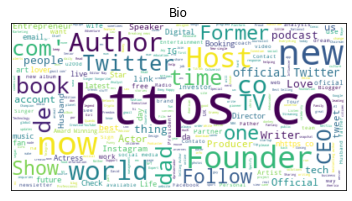

Most common words :
https co
new
now
Founder
Host


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
#Keywords from users' bio and wikipedia page
def word_cloud(data, title):

  cloud = WordCloud(background_color = "white", max_words = 300, mask = None,
                    stopwords = set(STOPWORDS)).generate(data)
  plt.imshow(cloud, interpolation='bilinear')
  plt.axis=('off')
  plt.title('{}'.format(title))
  ax = plt.gca()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()
  print('Most common words :')
  print(list(cloud.words_.keys())[0])
  print(list(cloud.words_.keys())[1])
  print(list(cloud.words_.keys())[2])
  print(list(cloud.words_.keys())[3])
  print(list(cloud.words_.keys())[4])


acc_file = np.load(r'/content/drive/MyDrive/Python_files/accounts.npy', allow_pickle=True)[()]

acc_data_np_bio = acc_file[:, 2]
file = open(r'/content/drive/MyDrive/Python_files/bio_text.txt', 'w+')
file.write(str(acc_data_np_bio))
file.close()
file = open(r'/content/drive/MyDrive/Python_files/bio_text.txt', 'r')
data = file.read()
file2 = open(r'/content/drive/MyDrive/Python_files/wiki.txt', 'r')
data2 = file2.read()

word_cloud(data, 'Bio')



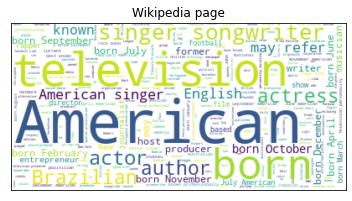

Most common words :
American
television
born
singer songwriter
actor


In [ ]:
word_cloud(data2, 'Wikipedia page')

Index(['Others', 'Media', 'Writer', 'Film', 'Music', 'Sport', 'Comedian',
       'Technology', 'Politics', 'Health', 'Tech'],
      dtype='object')
30.7


,Category percentage
Others,30.7
Media,19.9
Writer,12.2
Film,12.2
Music,12.0
Sport,3.9
Comedian,3.9
Technology,2.4
Politics,2.4
Health,0.3


            Category percentage
Others                     30.7
Media                      19.9
Writer                     12.2
Film                       12.2
Music                      12.0
Sport                       3.9
Comedian                    3.9
Technology                  2.4
Politics                    2.4
Health                      0.3
Tech                        0.1


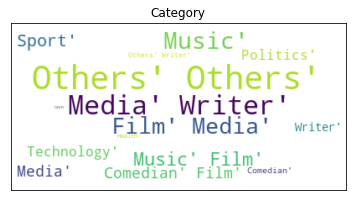

Most common words :
Others' Others'
Media' Writer'
Music'
Film' Media'
Music' Film'


In [ ]:
cursor.execute('''SELECT * FROM users_category ''')
df = pd.DataFrame(cursor.fetchall(), columns=['Name', 'Category'])
category = df['Category'].str.split(',', expand=True)
category = category.to_numpy().flatten()


pd_category = pd.Series(category).str.replace(' ', '')

#Category with percentage
category_percent = round(pd_category.value_counts(normalize=True) * 100, 1)
df_c = pd.DataFrame(category_percent, columns=['Category percentage'])
print(df_c.index)
print(df_c.iloc[0][0])
display(df_c)

data3 = category[category != None]
data3 = np.array_str(data3)
print(df_c)
word_cloud(data3, 'Category')

In [ ]:
try:
  cursor.execute('''DELETE FROM CATEGORY''')
except sqlite3.OperationalError:
  pass
cursor.execute('''CREATE TABLE IF NOT EXISTS CATEGORY(
                  CATEGORY varchar(30),
                  PERCENTAGE varchar(30))''')
for num in range(len(df_c)):
  category = df_c.index[num]
  percentage = df_c.iloc[num][0]
  cursor.execute('''INSERT INTO CATEGORY VALUES (?,?)''', (category, percentage))
cursor.execute('SELECT * FROM CATEGORY')
print(cursor.fetchall())
conn.commit()

[('Others', '30.7'), ('Media', '19.9'), ('Writer', '12.2'), ('Film', '12.2'), ('Music', '12.0'), ('Sport', '3.9'), ('Comedian', '3.9'), ('Technology', '2.4'), ('Politics', '2.4'), ('Health', '0.3'), ('Tech', '0.1')]


In [ ]:
#SQL tables
#1.Usernames
#2.users_category

#Select first 50 with no order
cursor.execute('''SELECT *
                  FROM Usernames''')
df = pd.DataFrame(cursor.fetchall())
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

display(df)

,0,1,2,3,4,5
0,name,username,followers,following,tweets,join_date
1,World Economic Forum,Davos,851170,944,43916,2010-01-07
2,Dwight Howard,DwightHoward,6383676,7109,23534,2008-10-16
3,threadless,threadless,1733162,593550,33368,2007-04-21
4,Sockamillion,sockington,1139348,809,8145,2007-03-19
...,...,...,...,...,...,...
515,Drizzy,Drake,39435476,604,1793,2009-03-28
516,UEFA Champions League,ChampionsLeague,39160354,606,79847,2012-07-05
517,Harry Styles.,Harry_Styles,37415961,1823,5603,2010-08-22
518,BTS_official,bts_bighit,37407969,26,9918,2013-05-07


In [ ]:
#Delete first row
cursor.execute('''DELETE
                  FROM USER_DATA
                  WHERE ROWID=1''')

cursor.execute('SELECT * FROM USER_DATA')
df = pd.DataFrame(cursor.fetchall())
display(df)

,0,1,2,3,4,5
0,World Economic Forum,Davos,851170,944,43916,2010-01-07
1,Dwight Howard,DwightHoward,6383676,7109,23534,2008-10-16
2,threadless,threadless,1733162,593550,33368,2007-04-21
3,Sockamillion,sockington,1139348,809,8145,2007-03-19
4,Nightline,Nightline,1135832,435,76166,2009-01-29
...,...,...,...,...,...,...
514,Drizzy,Drake,39435476,604,1793,2009-03-28
515,UEFA Champions League,ChampionsLeague,39160354,606,79847,2012-07-05
516,Harry Styles.,Harry_Styles,37415961,1823,5603,2010-08-22
517,BTS_official,bts_bighit,37407969,26,9918,2013-05-07


In [ ]:
#TOP 30 TWITTER ACCOUNTS BY FOLLOWERS


cursor.execute('SELECT * FROM USER_DATA ORDER BY FOLLOWER DESC LIMIT 30')
df = pd.DataFrame(cursor.fetchall())
df = df.rename(columns={0:'NAME',1:'USERNAME',2:'FOLLOWER',3:'FOLLOWING',
                        4:'TWEET',5:'JOIN_DATE'})
display(df)

,NAME,USERNAME,FOLLOWER,FOLLOWING,TWEET,JOIN_DATE
0,Barack Obama,BarackObama,130828350,586535,16383,2007-03-05
1,Justin Bieber,justinbieber,114279814,285204,31425,2009-03-28
2,KATY PERRY,katyperry,108813908,236,11550,2009-02-20
3,Rihanna,rihanna,104698845,995,10617,2009-10-02
4,Cristiano Ronaldo,Cristiano,97484768,60,3766,2010-06-14
5,Taylor Swift,taylorswift13,90091071,0,716,2008-12-06
6,Lady Gaga,ladygaga,84234561,118439,9726,2008-03-26
7,Ellen DeGeneres,TheEllenShow,77625019,26431,23630,2008-08-14
8,Narendra Modi,narendramodi,75914735,2430,32032,2009-01-10
9,YouTube,YouTube,74313978,1206,42656,2007-11-13


In [ ]:
#Category table

cursor.execute('SELECT * FROM users_category LIMIT 30')
df2 = pd.DataFrame(cursor.fetchall())
df2 = df2.rename(columns={0:'NAME',1:'CATEGORY'})
display(df2)

,NAME,CATEGORY
0,World Economic Forum,Others
1,Dwight Howard,Sport
2,Threadless,"Art, Tech"
3,Sockamillion,Others
4,Nightline,Media
5,Paul Pierce,Sport
6,Adventuregirl,Others
7,Take Care Of Yourself,Media
8,Ryan Penagos Black Lives Matter,Others
9,Steven Johnson,Others


In [ ]:
#INNER JOIN with 2 different tables
cursor.execute('''SELECT USER_DATA.NAME, USERNAME, FOLLOWER, FOLLOWING, JOIN_DATE, CATEGORY FROM USER_DATA
                  INNER JOIN users_category
                  ON USER_DATA.NAME = users_category.NAME
                  ORDER BY FOLLOWER DESC''')
df3 = pd.DataFrame(cursor.fetchall())
display(df3)

,0,1,2,3,4,5
0,Barack Obama,BarackObama,130828350,586535,2007-03-05,Politics
1,Justin Bieber,justinbieber,114279814,285204,2009-03-28,"Music, Media"
2,Rihanna,rihanna,104698845,995,2009-10-02,"Music, Film"
3,Cristiano Ronaldo,Cristiano,97484768,60,2010-06-14,Others
4,Taylor Swift,taylorswift13,90091071,0,2008-12-06,Music
5,Lady Gaga,ladygaga,84234561,118439,2008-03-26,"Music, Film"
6,Narendra Modi,narendramodi,75914735,2430,2009-01-10,Politics
7,Kim Kardashian West,KimKardashian,71237966,120,2009-03-19,Media
8,Selena Gomez,selenagomez,65578326,1074,2009-03-09,"Music, Film"
9,Justin Timberlake,jtimberlake,63294334,330,2009-03-25,"Music, Film"
